In [52]:
import numpy as np 
import matplotlib.pyplot as plt
import numpy.random as ra
import pandas as pd
import cross_pspec
import pspec
import HERA_hack
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
freq_fid = 150

dishes = np.array([[0,0],[0,55],[30,30],[0,60],[2,55],[47,2],[45,23],[56,21],[30,115],[48,52],[100,100],[0,200],[115,30],[33,31],[49,11],[21,24],[25,6],[56,9],[12,13],[16,17],[38,17],[60,14],[26,28],[6,45],[3,37],[12,55],[200,0],[145,13],[134,65],[139,163]])

#observable corners of the sky [lat,long]
acorner = np.array([[120,270],[122,280],[120,280],[122,270]])

HERA = HERA_hack.telescope(dishes, latitude=-30, channel_width=1., Tsys=300, beam_width=3, beam = 'gaussian')

obs = HERA_hack.observation(HERA, 100, 100, 0.01,acorner,1, 0.2, norm = False, pbeam = False)



In [21]:
##FOREGROUNDS###

def generate_foregrounds():
    ############ SYNCHRO EMISSION ############
    alpha_0_syn = 2.8
    sigma_syn = 0.1
    Asyn = 335.4 #K

    pixel_flux_syn = []

    alpha_syn = np.random.normal(alpha_0_syn,sigma_syn,obs.Npix)

    for i in range(obs.Npix):
        flux = Asyn*(obs.freq/freq_fid)**(-alpha_syn[i])
        pixel_flux_syn.append(flux)




    ########### FREE FREE EMISSION ##########

    alpha_0_ff = 2.15
    sigma_ff = 0.01
    Aff = 33.5 #K

    pixel_flux_ff = []

    alpha_ff = np.random.normal(alpha_0_ff,sigma_ff,obs.Npix)

    for i in range(obs.Npix):
        flux = Aff*(obs.freq/freq_fid)**(-alpha_ff[i])
        pixel_flux_ff.append(flux)

    ########### UNRES POINT SOURCE ###########

    gamma = 1.75

    def dnds(s):
        return 4.*(s/880)**(-gamma)

    s = np.arange(8,100,1) #maybe make this an argument 
    n_sources = 10

    pdf = np.asarray([s,dnds(s)]) #0 is s, 1 is dnds
    prob = pdf[1]/float(sum(pdf[1]))
    cum_prob = np.cumsum(prob)

    def gen_fluxes(N):
        R = ra.uniform(0, 1, N)
        #Here we first find the bin interval that random number lies in min(cum_prob[])
        #then we find the flux who's index is that cum_prob
        #repat for all r in R
        return [int(s[np.argwhere(cum_prob == min(cum_prob[(cum_prob - r) > 0]))]) for r in R]

    alpha_0 = 2.5
    sigma = 0.5

    theta_res = np.abs(np.cos(obs.observable_coordinates()[1,0])-np.cos(obs.observable_coordinates()[0,0]))
    phi_res = obs.observable_coordinates()[30,1]- obs.observable_coordinates()[1,1]
    omega_pix = theta_res*phi_res
    factor = 1.4e-6*((obs.freq/freq_fid)**(-2))*(omega_pix**(-1))

    pixel_flux = []

    for i in range(obs.Npix):
        alpha = np.random.normal(alpha_0,sigma,n_sources)
        S_star = gen_fluxes(n_sources)
        sum_fluxes = 0 

        for i in range(n_sources-1):
            sum_fluxes += factor*S_star[i]*(obs.freq/freq_fid)**(-alpha[i])

        pixel_flux.append(sum_fluxes/n_sources)


    ########## TOTAL FG ################

    pixel_flux = np.asarray(pixel_flux)
    pixel_flux_ff = np.asarray(pixel_flux_ff)
    pixel_flux_syn = np.asarray(pixel_flux_syn)

    total_fg = pixel_flux + pixel_flux_ff + pixel_flux_syn

    return total_fg

In [40]:
noise_1 = np.real(obs.generate_map_noise())
fg_1= generate_foregrounds()

npix = len(noise_1)

#making separate arrays of theta and phi for data vis
x = np.zeros(npix)
y = np.zeros_like(x)

for i in range(len(obs.observable_coordinates())):
    x[i]= obs.observable_coordinates()[i,1] #phi
    y[i] = obs.observable_coordinates()[i,0]#theta



df_obs = pd.DataFrame.from_dict(np.array([x,y,noise_1]).T)
df_obs.columns = ['phi','theta','temp']

pivotted_obs= df_obs.pivot('theta','phi','temp')

pivotted_obs.shape

noise_1 = np.reshape(noise_1,(30,50))
fg_1 = np.reshape(fg_1,(30,50))


/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/HERA Hack/cross_pspec.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  break
/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/HERA Hack/cross_pspec.py:88: RuntimeWarning: invalid value encountered in true_divide
  


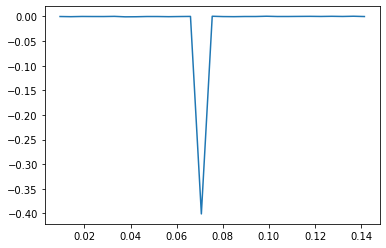

In [82]:
cross_spec_NFG = cross_pspec.make_cross_power_spectrum(noise_1,fg_1,5,30)

plt.plot(cross_spec_NFG[0],cross_spec_NFG[1])

/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/HERA Hack/pspec.py:80: RuntimeWarning: invalid value encountered in true_divide
  pk = (a/c) /((delta*npix)**2)


Text(0.5, 1.0, 'Power Spectrum Test')

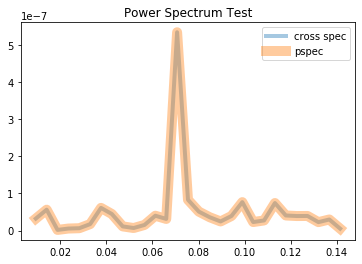

In [80]:
cross_spec_NN = cross_pspec.make_cross_power_spectrum(noise_1,noise_1,5,30)
powerspec = pspec.make_power_spectrum(noise_1,5,30)

plt.plot(cross_spec_NN[0],cross_spec_NN[1],linewidth= 4, alpha = 0.4, label = 'cross spec')
plt.plot(powerspec[0],powerspec[1],linewidth = 10,alpha = 0.4 , label = 'pspec' )
plt.legend()
plt.title('Power Spectrum Test')


In [76]:
len(noise_1.shape)
x = np.ones(1500,)


1